```Citation for data: Clough, P. and Stevenson, M. Developing A Corpus of Plagiarised Short Answers, Language Resources and Evaluation: Special Issue on Plagiarism and Authorship Analysis, In Press. [Download]```

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv (os.path.join ("dataset", "file_information.csv"))
data.head ()

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pB_taska.txt,a,non
2,g0pC_taska.txt,a,heavy
3,g0pD_taska.txt,a,cut
4,g0pE_taska.txt,a,light


In [3]:
files_text = []

for file in data.File.values :
    files_text.append (open (os.path.join ("dataset", file), 'r', encoding="cp437").read ())

In [4]:
print (len (files_text))

19


In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download ('punkt')
nltk.download ('stopwords')

def pre_process (_sentences) :
    # Get the Stopwords of English Language
    en_stops = set (stopwords.words ('english'))
    processed_sentences = []

    for sentence in _sentences :
        #print (sentence)
        sentence = re.sub (r'[^\w\s]','', sentence)
        lower_sen = sentence.lower ()
        token_sen = word_tokenize (lower_sen)

        #print (token_sen)

        new_sentence = []
        for word in token_sen:
            if word not in en_stops:
                new_sentence.append (word)
                #print (word)

        processed_sentences.append (new_sentence)
    return processed_sentences

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shraeyas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shraeyas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
sentences = []
for file_text in files_text :
    sentences.append (pre_process ([file_text]))        
print (len(sentences))

19


In [7]:
from gensim.models.doc2vec import TaggedDocument
tagged_data = [TaggedDocument (words = _d[0], tags = [str (i)]) for i, _d in enumerate (sentences)]

In [8]:
print(tagged_data[0][0])
print(len(tagged_data))

['inheritance', 'basic', 'concept', 'objectoriented', 'programming', 'basic', 'idea', 'create', 'new', 'classes', 'add', 'extra', 'detail', 'existing', 'classes', 'done', 'allowing', 'new', 'classes', 'reuse', 'methods', 'variables', 'existing', 'classes', 'new', 'methods', 'classes', 'added', 'specialise', 'new', 'class', 'inheritance', 'models', 'γçiskindofγç', 'relationship', 'entities', 'objects', 'example', 'postgraduates', 'undergraduates', 'kinds', 'student', 'kind', 'relationship', 'visualised', 'tree', 'structure', 'γçÿstudentγçö', 'would', 'general', 'root', 'node', 'γçÿpostgraduateγçö', 'γçÿundergraduateγçö', 'would', 'specialised', 'extensions', 'γçÿstudentγçö', 'node', 'child', 'nodes', 'relationship', 'γçÿstudentγçö', 'would', 'known', 'superclass', 'parent', 'class', 'whereas', 'γçÿpostgraduateγçö', 'would', 'known', 'subclass', 'child', 'class', 'γçÿpostgraduateγçö', 'class', 'extends', 'γçÿstudentγçö', 'class', 'inheritance', 'occur', 'several', 'layers', 'visualised',

In [9]:
from gensim.models.doc2vec import Doc2Vec

model = Doc2Vec (vector_size = 100, window = 19, min_count = 5, workers = 8, epochs = 1000, alpha = 0.03, min_alpha = 0.002)
model.build_vocab (tagged_data)
model.train (tagged_data, total_examples = model.corpus_count, epochs = model.epochs)

import os
model_path = os.path.join ("model", "Doc2Vec_Document.bin")
model.save(model_path)

In [10]:
test_sen = files_text [16]
processed = pre_process ([test_sen])

print ("V1_infer", processed[0] == tagged_data[0][0])

v1 = model.infer_vector (processed [0])

model.docvecs.most_similar (positive = [v1], topn = 5)

V1_infer False


<ipython-input-10-481c8ffb6752>:8: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  model.docvecs.most_similar (positive = [v1], topn = 5)


[('16', 0.9596492648124695),
 ('4', 0.8337626457214355),
 ('14', 0.6664733290672302),
 ('3', 0.5834048986434937),
 ('11', 0.5444937348365784)]

In [11]:
x = []
for file_text in files_text :
    processed = pre_process ([file_text])

    #print ("V1_infer", processed[0] == tagged_data[0][0])

    v = model.infer_vector (processed [0])
    x.append (v)

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [21]:
len(principalDf)

19

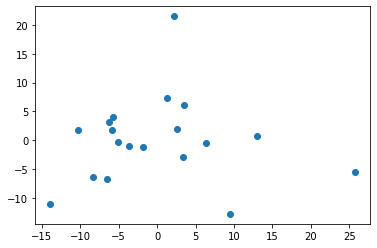

In [27]:
import matplotlib.pyplot as plt
plt.scatter (principalDf.pc1.values, principalDf.pc2.values)

In [35]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
#import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [49]:
x = principalDf.values
kmeans = KMeans (5)
kmeans.fit (x)

KMeans(n_clusters=5)

In [50]:
identified_clusters = kmeans.fit_predict(x)
identified_clusters

array([0, 2, 0, 0, 4, 2, 0, 1, 2, 0, 2, 4, 0, 2, 0, 2, 4, 3, 1])

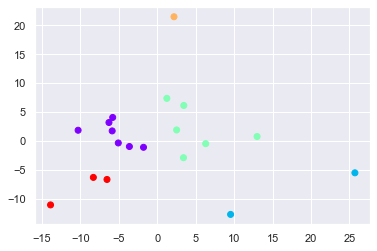

In [51]:
data_with_clusters = data.copy()
data_with_clusters['Clusters'] = identified_clusters 
plt.scatter(principalDf.pc1.values, principalDf.pc2.values, c = identified_clusters, cmap='rainbow')

Text(0, 0.5, 'WCSS')

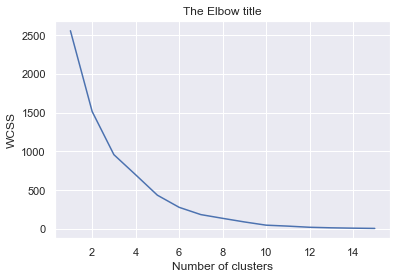

In [58]:
wcss = []
for i in range (1,16) :
    kmeans = KMeans (i)
    kmeans.fit (x)
    wcss_iter = kmeans.inertia_
    wcss.append (wcss_iter)

number_clusters = range (1, 16)
plt.plot (number_clusters, wcss)
plt.title ('The Elbow title')
plt.xlabel ('Number of clusters')
plt.ylabel ('WCSS')